## Data Preparation

#### ChEMBL

In [1]:
from pathlib import Path

import pandas as pd
from pandarallel import pandarallel
from rdkit import Chem, RDLogger
from rdkit.Chem import PandasTools

In [2]:
import sys

sys.path.append(str(Path.cwd().parent))

from src.utils import standardize_mol, CompoundLibraryFilter

In [3]:
# disable RDKit C++ log
RDLogger.DisableLog('rdApp.info')

In [4]:
HERE = Path.cwd().parent
path_data = HERE / "data" / "raw"

In [5]:
chembl = pd.read_csv(path_data / "chembl_35_NP.csv")
chembl.head(3)

,chembl_id,smiles
0,CHEMBL1000,O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1
1,CHEMBL100014,CCCC(=O)OCOC(=O)C(C)(C)C
2,CHEMBL100042,CO/C(CO[C@H]1O[C@H](C)[C@@H](OC)[C@H](OC)[C@@H...


In [6]:
PandasTools.AddMoleculeColumnToFrame(chembl, smilesCol="smiles")

[14:12:47] WARNING: not removing hydrogen atom without neighbors
[14:12:47] WARNING: not removing hydrogen atom without neighbors
[14:12:47] WARNING: not removing hydrogen atom without neighbors


In [ ]:
chembl["clean_mol"] = chembl["ROMol"].apply(standardize_mol)

In [8]:
pandarallel.initialize(nb_workers=6, progress_bar=True)
chembl["clean_mol"] = chembl["ROMol"].parallel_apply(standardize_mol)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[14:14:32] WARNING: not removing hydrogen atom without neighbors
[14:14:32] WARNING: not removing hydrogen atom without neighbors
[14:14:32] WARNING: not removing hydrogen atom without neighbors
[14:14:32] WARNING: not removing hydrogen atom without neighbors
[14:14:32] WARNING: not removing hydrogen atom without neighbors
[14:14:32] WARNING: not removing hydrogen atom without neighbors
[14:14:45] Can't kekulize mol.  Unkekulized atoms: 7 15


In [9]:
chembl.head(3)

,chembl_id,smiles,ROMol,clean_mol
0,CHEMBL1000,O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1,<rdkit.Chem.rdchem.Mol object at 0x75e3a47153f0>,<rdkit.Chem.rdchem.Mol object at 0x75e3a6dd52b0>
1,CHEMBL100014,CCCC(=O)OCOC(=O)C(C)(C)C,<rdkit.Chem.rdchem.Mol object at 0x75e3a4715380>,<rdkit.Chem.rdchem.Mol object at 0x75e3a6dd5260>
2,CHEMBL100042,CO/C(CO[C@H]1O[C@H](C)[C@@H](OC)[C@H](OC)[C@@H...,<rdkit.Chem.rdchem.Mol object at 0x75e3a4715540>,<rdkit.Chem.rdchem.Mol object at 0x75e3a6dd5210>


In [10]:
chembl["clean_smiles"] = chembl["clean_mol"].apply(Chem.MolToSmiles)

In [11]:
chembl[["chembl_id", "clean_smiles"]].to_csv(
    HERE / "data" / "interim" / "chembl_35_NP_for_deglycosilation.csv", index=False
)

At this point, sugars were removed using the CDK Sugar Remover extension for KNIME

In [5]:
chembl_no_sugars = pd.read_csv(HERE / "data" / "interim" / "chembl_35_NP_no_sugars.csv")
chembl_no_sugars.sample(4)

,chembl_id,clean_smiles,smiles_no_sugar
42535,CHEMBL3185647,Cc1cc(Cl)c(C)cc1Cl,[C]C1=[C]C(Cl)=C([C])[C]=C1Cl
22337,CHEMBL1881624,CC(C)CC[C@@H](O)[C@](C)(O)C1CC[C@@]2(O)C3=CC(=...,[C][C]([C])[C][C][C]([O])[C@]([C])([O])[C]1[C]...
66702,CHEMBL451013,CCC(C)C(=O)O[C@H]1[C@H](OC(=O)/C=C/c2ccccc2)C(...,[C][C][C]([C])C(=O)O[C]1[C](OC(=O)/[C]=[C]/C2=...
78881,CHEMBL4847962,CC(=O)O[C@H]1CC(C)(C)[C@@H]2CC[C@]3(C)C[C@]12C...,[C]C(=O)O[C]1[C]C([C])([C])[C]2[C][C][C@]3([C]...


In [6]:
type(chembl_no_sugars.loc[97882, "smiles_no_sugar"])

float

In [7]:
chembl_no_sugars.fillna("", inplace=True)
chembl_no_sugars.loc[97882, "smiles_no_sugar"]

''

In [8]:
for _, row in chembl_no_sugars.iterrows():
    if row["smiles_no_sugar"] == "":
        row["smiles_no_sugar"] = row["clean_smiles"]

In [9]:
chembl_no_sugars.loc[97882, "smiles_no_sugar"]

'N=C(N)c1ccc2nc(Cc3nc4ccc(C(=N)N)cc4[nH]3)[nH]c2c1'

In [ ]:
PandasTools.AddMoleculeColumnToFrame(chembl_no_sugars, smilesCol="smiles_no_sugar")

In [11]:
chembl_no_sugars.head(2)

,chembl_id,clean_smiles,smiles_no_sugar,ROMol
0,CHEMBL1000,O=C(O)COCCN1CCN(C(c2ccccc2)c3ccc(Cl)cc3)CC1,O=C([O])[C]O[C][C]N1[C][C]N([C](C2=[C][C]=[C][...,<rdkit.Chem.rdchem.Mol object at 0x7b3fea816880>
1,CHEMBL100014,CCCC(=O)OCOC(=O)C(C)(C)C,[C][C][C]C(=O)O[C]OC(=O)C([C])([C])[C],<rdkit.Chem.rdchem.Mol object at 0x7b3fea816110>


Interestingly, CDK mols are left as some sort of radicals (apparently, the mol2smi transformation does not work well and the implicit hydrogens are somehow treated as radical sources). The smiles have to be manually modified

In [ ]:
def remove_false_radicals(mol):
    for atom in mol.GetAtoms():
        atom.SetNumRadicalElectrons(0)
    new_smi = Chem.MolToSmiles(mol)  # necessary to avoid conflict with mutable objects in pandas
    return new_smi

In [13]:
pandarallel.initialize(nb_workers=6, progress_bar=True)
chembl_no_sugars["no_radical_smi"] = chembl_no_sugars["ROMol"].parallel_apply(remove_false_radicals)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [14]:
chembl_no_sugars["no_radical_smi"].loc[:3]

0          OC(=O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1
1                             CCCC(=O)OCOC(=O)C(C)(C)C
2    C/C(=C\c1ccc(O)cc1)C(=O)NC1C(CO)OC(n2cnc3c(N(C...
3    CC(=O)NC(Cc1ccccc1)C(=O)N1CCCC1C(=O)NC(CCCCN)B...
Name: no_radical_smi, dtype: object

In [15]:
PandasTools.AddMoleculeColumnToFrame(chembl_no_sugars, smilesCol="no_radical_smi",
                                     molCol="no_radical_mol")

In [16]:
chembl_no_sugars["clean_mol"] = chembl_no_sugars["no_radical_mol"].parallel_apply(standardize_mol)

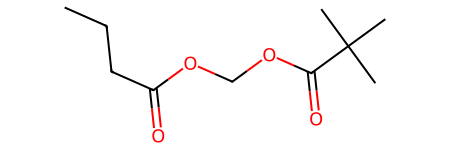

In [17]:
chembl_no_sugars["clean_mol"][1]

In [18]:
compound_filter = CompoundLibraryFilter(mol_col="clean_mol")
chembl_no_sugars_filtered = compound_filter.filter(chembl_no_sugars)

After isotopes: (97868, 8)


After unusual: (97783, 9)


After heavy: (95850, 10)


In [19]:
print(chembl_no_sugars.shape)
print(chembl_no_sugars_filtered.shape)

(97884, 7)
(78163, 7)


In [20]:
chembl_no_sugars_filtered.columns

Index(['chembl_id', 'clean_smiles', 'smiles_no_sugar', 'ROMol',
       'no_radical_smi', 'no_radical_mol', 'clean_mol'],
      dtype='object')

In [21]:
chembl_no_sugars_filtered["taut_mol"] = chembl_no_sugars_filtered["clean_mol"].parallel_apply(
    standardize_mol, canonicalize_tautomer=True
)

[16:37:33] Tautomer enumeration stopped at 100 tautomers: max tautomers reached
[16:37:33] Tautomer enumeration stopped at 100 tautomers: max tautomers reached
[16:37:34] Tautomer enumeration stopped at 100 tautomers: max tautomers reached
[16:37:34] Tautomer enumeration stopped at 100 tautomers: max tautomers reached
[16:37:34] Tautomer enumeration stopped at 100 tautomers: max tautomers reached
[16:37:34] Tautomer enumeration stopped at 100 tautomers: max tautomers reached
[16:37:34] Tautomer enumeration stopped at 100 tautomers: max tautomers reached
[16:37:34] Tautomer enumeration stopped at 100 tautomers: max tautomers reached
[16:37:34] Tautomer enumeration stopped at 100 tautomers: max tautomers reached
[16:37:35] Tautomer enumeration stopped at 100 tautomers: max tautomers reached
[16:37:35] Tautomer enumeration stopped at 100 tautomers: max tautomers reached
[16:37:35] Tautomer enumeration stopped at 100 tautomers: max tautomers reached
[16:37:35] Tautomer enumeration stopped 

In [22]:
chembl_no_sugars_filtered["taut_smiles"] = chembl_no_sugars_filtered["taut_mol"].apply(Chem.MolToSmiles)

In [23]:
chembl_no_sugars_filtered.head(3)

,chembl_id,clean_smiles,smiles_no_sugar,ROMol,no_radical_smi,no_radical_mol,clean_mol,taut_mol,taut_smiles
0,CHEMBL1000,O=C(O)COCCN1CCN(C(c2ccccc2)c3ccc(Cl)cc3)CC1,O=C([O])[C]O[C][C]N1[C][C]N([C](C2=[C][C]=[C][...,<rdkit.Chem.rdchem.Mol object at 0x7b3fea816880>,OC(=O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7b3feff6bf40>,<rdkit.Chem.rdchem.Mol object at 0x7b3ff7b2d710>,<rdkit.Chem.rdchem.Mol object at 0x7b3ff6b01a80>,O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1
1,CHEMBL100014,CCCC(=O)OCOC(=O)C(C)(C)C,[C][C][C]C(=O)O[C]OC(=O)C([C])([C])[C],<rdkit.Chem.rdchem.Mol object at 0x7b3fea816110>,CCCC(=O)OCOC(=O)C(C)(C)C,<rdkit.Chem.rdchem.Mol object at 0x7b3ff7b3c190>,<rdkit.Chem.rdchem.Mol object at 0x7b3ff7b2c950>,<rdkit.Chem.rdchem.Mol object at 0x7b3ff6b00720>,CCCC(=O)OCOC(=O)C(C)(C)C
2,CHEMBL100042,CO/C(/CO[C@H]1O[C@H](C)[C@@H](OC)[C@H](OC)[C@@...,[O]C1=[C][C]=C(/[C]=C(\[C])/C(=O)[N][C]2[C]([O...,<rdkit.Chem.rdchem.Mol object at 0x7b3fea816b90>,C/C(=C\c1ccc(O)cc1)C(=O)NC1C(CO)OC(n2cnc3c(N(C...,<rdkit.Chem.rdchem.Mol object at 0x7b3ff7b3c040>,<rdkit.Chem.rdchem.Mol object at 0x7b3ff7b2d6c0>,<rdkit.Chem.rdchem.Mol object at 0x7b3ff6b03e20>,CC(=Cc1ccc(O)cc1)C(=O)NC1C(CO)OC(n2cnc3c(N(C)C...


In [24]:
chembl_no_sugars_filtered[["chembl_id", "taut_smiles"]].to_csv(
    HERE / "data" / "processed" / "chembl_35_NP_cleaned.csv", index=False
)

#### DrugBank

In [3]:
LIBRARIES_PATH = Path("/home/freddy/Documents/compound_collections")

file = LIBRARIES_PATH / "drugbank_5_1_13" / "drugbank_5_1_13_structures.sdf"

In [4]:
mol_supplier = Chem.MultithreadedSDMolSupplier(file, numWriterThreads=6, sanitize=False, removeHs=False)
# mol_supplier = Chem.MultithreadedSDMolSupplier(file, numWriterThreads=6)
# mol_supplier = Chem.SDMolSupplier(file)

In [5]:
mol = next(mol_supplier)

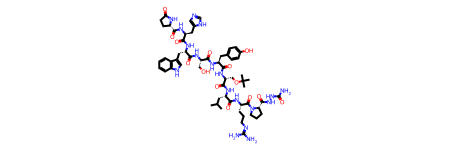

In [6]:
mol

In [7]:
for k in mol.GetPropsAsDict().keys():
    print(k)

DATABASE_ID
DATABASE_NAME
SMILES
INCHI_IDENTIFIER
INCHI_KEY
FORMULA
MOLECULAR_WEIGHT
EXACT_MASS
JCHEM_ACCEPTOR_COUNT
JCHEM_ATOM_COUNT
JCHEM_AVERAGE_NEUTRAL_MICROSPECIES_CHARGE
JCHEM_AVERAGE_POLARIZABILITY
JCHEM_BIOAVAILABILITY
JCHEM_DONOR_COUNT
JCHEM_FORMAL_CHARGE
JCHEM_GHOSE_FILTER
JCHEM_IUPAC
ALOGPS_LOGP
JCHEM_LOGP
ALOGPS_LOGS
JCHEM_MDDR_LIKE_RULE
JCHEM_NEUTRAL_CHARGE
JCHEM_NUMBER_OF_RINGS
JCHEM_PHYSIOLOGICAL_CHARGE
JCHEM_PKA
JCHEM_PKA_STRONGEST_ACIDIC
JCHEM_PKA_STRONGEST_BASIC
JCHEM_POLAR_SURFACE_AREA
JCHEM_REFRACTIVITY
JCHEM_ROTATABLE_BOND_COUNT
JCHEM_RULE_OF_FIVE
ALOGPS_SOLUBILITY
JCHEM_TRADITIONAL_IUPAC
JCHEM_VEBER_RULE
DRUGBANK_ID
SECONDARY_ACCESSION_NUMBERS
DRUG_GROUPS
GENERIC_NAME
SYNONYMS
PRODUCTS
SALTS


In [8]:
mol.GetProp("_Name")

'[NO NAME]'

In [9]:
mol.GetProp("DATABASE_ID")

'DB00014'

In [10]:
mol.GetProp("SMILES")

'CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CNC2=CC=CC=C12)NC(=O)[C@H](CC1=CN=CN1)NC(=O)[C@@H]1CCC(=O)N1)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N1CCC[C@H]1C(=O)NNC(N)=O'

In [11]:
for n in mol.GetPropNames():
    print(n)

DATABASE_ID
DATABASE_NAME
SMILES
INCHI_IDENTIFIER
INCHI_KEY
FORMULA
MOLECULAR_WEIGHT
EXACT_MASS
JCHEM_ACCEPTOR_COUNT
JCHEM_ATOM_COUNT
JCHEM_AVERAGE_NEUTRAL_MICROSPECIES_CHARGE
JCHEM_AVERAGE_POLARIZABILITY
JCHEM_BIOAVAILABILITY
JCHEM_DONOR_COUNT
JCHEM_FORMAL_CHARGE
JCHEM_GHOSE_FILTER
JCHEM_IUPAC
ALOGPS_LOGP
JCHEM_LOGP
ALOGPS_LOGS
JCHEM_MDDR_LIKE_RULE
JCHEM_NEUTRAL_CHARGE
JCHEM_NUMBER_OF_RINGS
JCHEM_PHYSIOLOGICAL_CHARGE
JCHEM_PKA
JCHEM_PKA_STRONGEST_ACIDIC
JCHEM_PKA_STRONGEST_BASIC
JCHEM_POLAR_SURFACE_AREA
JCHEM_REFRACTIVITY
JCHEM_ROTATABLE_BOND_COUNT
JCHEM_RULE_OF_FIVE
ALOGPS_SOLUBILITY
JCHEM_TRADITIONAL_IUPAC
JCHEM_VEBER_RULE
DRUGBANK_ID
SECONDARY_ACCESSION_NUMBERS
DRUG_GROUPS
GENERIC_NAME
SYNONYMS
PRODUCTS
SALTS


In [ ]:
from pathlib import Path

import pandas as pd
from pandarallel import pandarallel
from rdkit import Chem, RDLogger
from rdkit.Chem import PandasTools

In [ ]:
import sys

sys.path.append(str(Path.cwd().parent))

from src.utils import standardize_mol, CompoundLibraryFilter, read_sdf

In [2]:
# disable RDKit C++ log
RDLogger.DisableLog('rdApp.*')

In [23]:
HERE = Path.cwd().parent
    
LIBRARIES_PATH = Path("/home/freddy/Documents/compound_collections")

file = LIBRARIES_PATH / "drugbank_5_1_13" / "drugbank_5_1_13_structures.sdf"

In [5]:
molecules = read_sdf(file)

In [7]:
molecules.shape

(12316, 41)

In [11]:
molecules.columns

Index(['DATABASE_ID', 'DATABASE_NAME', 'SMILES', 'INCHI_IDENTIFIER',
       'INCHI_KEY', 'FORMULA', 'MOLECULAR_WEIGHT', 'EXACT_MASS',
       'JCHEM_ACCEPTOR_COUNT', 'JCHEM_ATOM_COUNT',
       'JCHEM_AVERAGE_NEUTRAL_MICROSPECIES_CHARGE',
       'JCHEM_AVERAGE_POLARIZABILITY', 'JCHEM_BIOAVAILABILITY',
       'JCHEM_DONOR_COUNT', 'JCHEM_FORMAL_CHARGE', 'JCHEM_GHOSE_FILTER',
       'JCHEM_IUPAC', 'ALOGPS_LOGP', 'JCHEM_LOGP', 'ALOGPS_LOGS',
       'JCHEM_MDDR_LIKE_RULE', 'JCHEM_NEUTRAL_CHARGE', 'JCHEM_NUMBER_OF_RINGS',
       'JCHEM_PHYSIOLOGICAL_CHARGE', 'JCHEM_PKA', 'JCHEM_PKA_STRONGEST_ACIDIC',
       'JCHEM_PKA_STRONGEST_BASIC', 'JCHEM_POLAR_SURFACE_AREA',
       'JCHEM_REFRACTIVITY', 'JCHEM_ROTATABLE_BOND_COUNT',
       'JCHEM_RULE_OF_FIVE', 'ALOGPS_SOLUBILITY', 'JCHEM_TRADITIONAL_IUPAC',
       'JCHEM_VEBER_RULE', 'DRUGBANK_ID', 'SECONDARY_ACCESSION_NUMBERS',
       'DRUG_GROUPS', 'GENERIC_NAME', 'SYNONYMS', 'PRODUCTS', 'SALTS'],
      dtype='object')

In [12]:
PandasTools.AddMoleculeColumnToFrame(molecules, smilesCol="SMILES")

In [17]:
print(molecules.shape[0])
molecules.dropna(subset=["ROMol"], inplace=True)
print(molecules.shape[0])

12316
12307


In [18]:
pandarallel.initialize(nb_workers=6, progress_bar=True)
molecules["taut_mol"] = molecules["ROMol"].parallel_apply(standardize_mol, canonicalize_tautomer=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [19]:
compound_filter = CompoundLibraryFilter(mol_col="taut_mol")
drugbank_filtered = compound_filter.filter(molecules)

In [20]:
drugbank_filtered["taut_smiles"] = drugbank_filtered["taut_mol"].apply(Chem.MolToSmiles)

In [21]:
drugbank_filtered.head(3)

,DATABASE_ID,DATABASE_NAME,SMILES,INCHI_IDENTIFIER,INCHI_KEY,FORMULA,MOLECULAR_WEIGHT,EXACT_MASS,JCHEM_ACCEPTOR_COUNT,JCHEM_ATOM_COUNT,...,DRUGBANK_ID,SECONDARY_ACCESSION_NUMBERS,DRUG_GROUPS,GENERIC_NAME,SYNONYMS,PRODUCTS,SALTS,ROMol,taut_mol,taut_smiles
1,DB00035,drugbank,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,NFLWUMRGJYTJIN-PNIOQBSNSA-N,C46H64N14O12S2,1069.22,1068.426955905,15,138,...,DB00035,BTD00112; BTD00061; BIOD00112; BIOD00061,approved,Desmopressin,1-(3-mercaptopropionic acid)-8-D-arginine-vaso...,Apo-desmopressin; Bipazen; DDAVP Rhinal Tube; ...,Desmopressin acetate; Desmopressin acetate anh...,<rdkit.Chem.rdchem.Mol object at 0x782d4f046b20>,<rdkit.Chem.rdchem.Mol object at 0x782d4e874040>,N=C(N)NCCCC(NC(=O)C1CCCN1C(=O)C1CSSCCC(=O)NC(C...
4,DB00114,drugbank,CC1=NC=C(COP(O)(O)=O)C(C=O)=C1O,InChI=1S/C8H10NO6P/c1-5-8(11)7(3-10)6(2-9-5)4-...,NGVDGCNFYWLIFO-UHFFFAOYSA-N,C8H10NO6P,247.1419,247.024573569,6,26,...,DB00114,NUTR00045,approved; investigational; nutraceutical,Pyridoxal phosphate,3-hydroxy-2-methyl-5-((phosphonooxy)methyl)-4-...,Amladex; Azesco; BumP DHA; Dexivite; Dyzbac; E...,Pyridoxal phosphate hydrate,<rdkit.Chem.rdchem.Mol object at 0x782d4f046c70>,<rdkit.Chem.rdchem.Mol object at 0x782d4e8771a0>,Cc1ncc(COP(=O)(O)O)c(C=O)c1O
7,DB00116,drugbank,NC1=NC(=O)C2=C(NCC(CNC3=CC=C(C=C3)C(=O)N[C@@H]...,InChI=1S/C19H23N7O6/c20-19-25-15-14(17(30)26-1...,MSTNYGQPCMXVAQ-KIYNQFGBSA-N,C19H23N7O6,445.4292,445.170981503,12,55,...,DB00116,NUTR00056,nutraceutical,Tetrahydrofolic acid,"5,6,7,8-tetrahydrofolate; 5,6,7,8-tetrahydrofo...",,,<rdkit.Chem.rdchem.Mol object at 0x782d4f046570>,<rdkit.Chem.rdchem.Mol object at 0x782d4e874860>,Nc1nc(=O)c2c([nH]1)NCC(CNc1ccc(C(=O)NC(CCC(=O)...


In [ ]:
drugbank_filtered[["DATABASE_ID", "taut_smiles"]].to_csv(
    HERE / "data" / "interim" / "drugbank_5_1_13_cleaned.csv", index=False
)

#### Enamine

In [ ]:
from pathlib import Path

import pandas as pd
from pandarallel import pandarallel
from rdkit import Chem, RDLogger
from rdkit.Chem import PandasTools

In [ ]:
import sys

sys.path.append(str(Path.cwd().parent))

from src.utils import standardize_mol, CompoundLibraryFilter, read_sdf

In [2]:
# disable RDKit C++ log
RDLogger.DisableLog('rdApp.*')

In [3]:
HERE = Path.cwd().parent
    
LIBRARIES_PATH = Path("/home/freddy/Documents/compound_collections")

enamine_file = LIBRARIES_PATH / "enamine_screening_collection_202504" / "Enamine_screening_collection_202504.sdf"

In [7]:
molecules = read_sdf(enamine_file)

In [8]:
molecules.shape

(4573370, 12)

In [9]:
molecules.columns

Index(['smiles', 'Catalog_ID', 'heavy_atoms', 'LogS', 'LogP', 'rotating_bonds',
       'PSA', 'hb_acceptors', 'hb_donors', 'SaltType', 'Collection', 'link'],
      dtype='object')

In [10]:
molecules["Collection"].unique()

array(['Legacy', 'HTS', 'Advanced', 'Functional', 'Premium'], dtype=object)

In [11]:
advanced_enamine = molecules.query("Collection == 'Advanced'").copy()
advanced_enamine.shape

(795982, 12)

In [13]:
PandasTools.AddMoleculeColumnToFrame(advanced_enamine, smilesCol="smiles")

In [14]:
print(advanced_enamine.shape[0])
advanced_enamine.dropna(subset=["ROMol"], inplace=True)
print(advanced_enamine.shape[0])

795982
795980


In [15]:
enamine_subset = advanced_enamine.sample(50_000, random_state=2025)
enamine_subset.shape

(50000, 13)

In [17]:
pandarallel.initialize(nb_workers=6, progress_bar=True)
enamine_subset["taut_mol"] = enamine_subset["ROMol"].parallel_apply(standardize_mol, canonicalize_tautomer=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [18]:
compound_filter = CompoundLibraryFilter(mol_col="taut_mol")
enamine_subset_filtered = compound_filter.filter(enamine_subset)

After isotopes: (50000, 15)


After unusual: (49977, 16)


After heavy: (49977, 17)


In [19]:
enamine_subset_filtered.shape

(49970, 14)

In [20]:
enamine_subset_filtered["taut_smiles"] = enamine_subset_filtered["taut_mol"].apply(Chem.MolToSmiles)

In [21]:
enamine_subset_filtered.head(3)

,smiles,Catalog_ID,heavy_atoms,LogS,LogP,rotating_bonds,PSA,hb_acceptors,hb_donors,SaltType,Collection,link,ROMol,taut_mol,taut_smiles
1967157,CO[C@H]1C[C@@H](CO)N(C(=O)CCN2CCN(C3=CC=CC=C3)...,Z2064095494,25,-1.877,1.834,6,56.25,5,1,,Advanced,https://www.enaminestore.com/catalog/Z2064095494,<rdkit.Chem.rdchem.Mol object at 0x738472499bd0>,<rdkit.Chem.rdchem.Mol object at 0x7383c1700f40>,CO[C@H]1C[C@@H](CO)N(C(=O)CCN2CCN(c3ccccc3)CC2)C1
4362161,C=CC(C)NC1=CC=C(CC(=O)NCC)C=C1,Z9033877828,17,-2.427,1.801,6,41.13,2,2,,Advanced,https://www.enaminestore.com/catalog/Z9033877828,<rdkit.Chem.rdchem.Mol object at 0x7383c2773ed0>,<rdkit.Chem.rdchem.Mol object at 0x7383c1700a90>,C=CC(C)Nc1ccc(CC(=O)NCC)cc1
4300198,COC(=O)C1(C)CC(NC(=O)COCC2CCN(C(=O)CC(C)OC)CC2...,Z8843144243,30,-2.156,-0.752,10,103.4,6,1,,Advanced,https://www.enaminestore.com/catalog/Z8843144243,<rdkit.Chem.rdchem.Mol object at 0x7383c2d6a110>,<rdkit.Chem.rdchem.Mol object at 0x7383c1701080>,COC(=O)C1(C)CC(NC(=O)COCC2CCN(C(=O)CC(C)OC)CC2...


In [ ]:
enamine_subset_filtered[["Catalog_ID", "taut_smiles"]].to_csv(
    HERE / "data" / "interim" / "enamine_advanced_50k_subset_cleaned.csv", index=False
)

## Internal compounds

In [1]:
from pathlib import Path

import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem import PandasTools

In [2]:
import sys

sys.path.append(str(Path.cwd().parent))

from src.utils import standardize_mol, CompoundLibraryFilter

In [3]:
# disable RDKit C++ log
RDLogger.DisableLog('rdApp.*')

In [4]:
HERE = Path.cwd().parent
path_file = HERE / "data" / "interim" / "Compounds_GreinerL.xlsx"

In [5]:
compounds = pd.read_excel(path_file)
compounds.head()

,cmpd_id,smiles
0,5a,[H]C1=CC2=C(C=C1)NC3=C2CC(N(C(OCC)=O)CC4)C4(C3...
1,5b,FC1=CC2=C(C=C1)NC3=C2CC(N(C(OCC)=O)CC4)C4(C3)C...
2,5c,ClC1=CC2=C(C=C1)NC3=C2C[C@](N(C(OCC)=O)CC4)([H...
3,5d,BrC1=CC2=C(C=C1)NC3=C2CC(N(C(OCC)=O)CC4)C4(C3)...
4,5e,O=C(N(CC1)C2CC3=C(NC4=C3C=C(OC(F)(F)F)C=C4)CC2...


In [6]:
PandasTools.AddMoleculeColumnToFrame(compounds, smilesCol="smiles")

In [7]:
compounds["taut_mol"] = compounds["ROMol"].apply(standardize_mol, canonicalize_tautomer=True)

In [8]:
compound_filter = CompoundLibraryFilter(mol_col="taut_mol", n_jobs=1)
compounds_filtered = compound_filter.filter(compounds)

After isotopes: (22, 5)
After unusual: (22, 6)
After heavy: (22, 7)


In [9]:
compounds_filtered["taut_smiles"] = compounds_filtered["taut_mol"].apply(Chem.MolToSmiles)

In [10]:
compounds_filtered.columns

Index(['cmpd_id', 'smiles', 'ROMol', 'taut_mol', 'taut_smiles'], dtype='object')

In [11]:
compounds_filtered[["cmpd_id", "taut_smiles"]].to_csv(
    HERE / "data" / "interim" / "compounds_GreinerL_cleaned.csv", index=False
)

In [1]:
from pathlib import Path

import pandas as pd
from pandarallel import pandarallel
from rdkit import Chem, RDLogger
from rdkit.Chem import PandasTools

In [2]:
HERE = Path.cwd().parent

In [3]:
df = pd.read_csv(HERE / "data" / "interim" / "chembl_35_NP_no_sugars.csv")
df.head()

,chembl_id,clean_smiles,smiles_no_sugar
0,CHEMBL1000,O=C(O)COCCN1CCN(C(c2ccccc2)c3ccc(Cl)cc3)CC1,O=C([O])[C]O[C][C]N1[C][C]N([C](C2=[C][C]=[C][...
1,CHEMBL100014,CCCC(=O)OCOC(=O)C(C)(C)C,[C][C][C]C(=O)O[C]OC(=O)C([C])([C])[C]
2,CHEMBL100042,CO/C(/CO[C@H]1O[C@H](C)[C@@H](OC)[C@H](OC)[C@@...,[O]C1=[C][C]=C(/[C]=C(\[C])/C(=O)[N][C]2[C]([O...
3,CHEMBL100109,CC(=O)N[C@H](Cc1ccccc1)C(=O)N2CCC[C@H]2C(=O)N[...,[C]C(=O)[N][C]([C]C1=[C][C]=[C][C]=[C]1)C(=O)N...
4,CHEMBL100116,CC(C)=CCN1CCC2(C)c3cc(O)ccc3CC1C2C,[C]C([C])=[C][C]N1[C][C]C2([C])C3=[C]C([O])=[C...


In [4]:
tmp = df["smiles_no_sugar"].iloc[:5]
tmp

0    O=C([O])[C]O[C][C]N1[C][C]N([C](C2=[C][C]=[C][...
1               [C][C][C]C(=O)O[C]OC(=O)C([C])([C])[C]
2    [O]C1=[C][C]=C(/[C]=C(\[C])/C(=O)[N][C]2[C]([O...
3    [C]C(=O)[N][C]([C]C1=[C][C]=[C][C]=[C]1)C(=O)N...
4    [C]C([C])=[C][C]N1[C][C]C2([C])C3=[C]C([O])=[C...
Name: smiles_no_sugar, dtype: object

In [21]:
import re

test = []
for smi in tmp:
    test.append(re.sub(r"\[([A-Za-z])\]", r"\1", smi))

In [22]:
test

['O=C(O)COCCN1CCN(C(C2=CC=CC=C2)C3=CC=C(Cl)C=C3)CC1',
 'CCCC(=O)OCOC(=O)C(C)(C)C',
 'OC1=CC=C(/C=C(\\C)/C(=O)NC2C(O)C(N3C=NC4=C(N(C)C)N=CN=C43)OC2CO)C=C1',
 'CC(=O)NC(CC1=CC=CC=C1)C(=O)N2CCCC2C(=O)NC(CCCCN)B(O)O',
 'CC(C)=CCN1CCC2(C)C3=CC(O)=CC=C3CC1C2C']